## Initialisation of different libraries

In [27]:
#initialization
import itertools as it
from scipy.sparse import csr_matrix
import scipy
import matplotlib.pyplot as plt
import numpy as np
pi = np.pi
import math

# import qtda module
import qtda_modules.qtda_module as qtda

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
import qiskit.extensions
# import basic plot tools
from qiskit.visualization import plot_histogram

## Define combinatorial laplacian

In [28]:
n_vertices = 3
S0 = [(0,0,1),(0,1,0), (1,0,0)]
S_test = [(0,1,0,0),(0,0,1,1)]
S1 = [(0,1,1),(1,1,0),(1,0,1)]
S2 = []
#S2 = [(1,1,1)]
S3 = []

state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

In [29]:
# k = 1
def combinatorial_laplacian(n_vertices, k, state_dict):
    return qtda.projected_combinatorial_laplacian(n_vertices, k, state_dict).toarray()

# combinatorial_laplacian = qtda.projected_combinatorial_laplacian(n_vertices, k, state_dict).toarray()

### Example for a combinatorial Laplacian

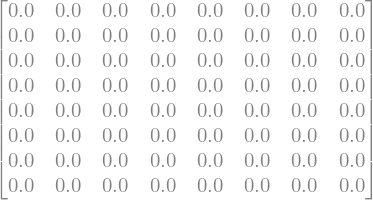

In [30]:
from sympy import Matrix, init_printing
init_printing()

display(Matrix(combinatorial_laplacian(3, 2, state_dict)))

## QPE is defined

In [31]:
import qiskit.extensions

# combinatorial_laplacian = np.pi/2*np.diag((1,1,1,1,1,1,1,1))

#unit = scipy.linalg.expm(1j*combinatorial_laplacian)
#gate = qiskit.extensions.UnitaryGate(unit)

In [32]:
def init(qc, num_qubits):
    for qubit in range(num_qubits):
        qc.h(qubit)
    return qc
#qpe = init(num_qubits,5, 6)
#qpe.draw()

In [33]:
def controledU(qc, rep, num_qubits, n_vertices, k, state_dict):
    repetitions = rep
    unit = scipy.linalg.expm(1j*combinatorial_laplacian(n_vertices, k, state_dict))
    gate = qiskit.extensions.UnitaryGate(unit)
    for counting_qubit in range(num_qubits):
        for i in range(repetitions):
            qc.append(gate.control(1), [counting_qubit] + list(range(num_qubits,num_qubits+n_vertices)))
        repetitions *= 2
    return qc
#controledU(1, num_qubits)
#qpe.draw()

In [34]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [35]:
def qpe_total(num_qubits, n_vertices, k, state_dict):
    qc = QuantumCircuit(num_qubits + n_vertices)
    for qubit in range(num_qubits):
        qc.h(qubit)
    controledU(qc, 1, num_qubits, n_vertices, k, state_dict)
    # Apply inverse QFT
    qft_dagger(qc, num_qubits)
    return qc

## Loop over the different ks

In [36]:
num_qubits = 4
k = 1

qpe_total(num_qubits, n_vertices, k, state_dict)

## Initialize input state

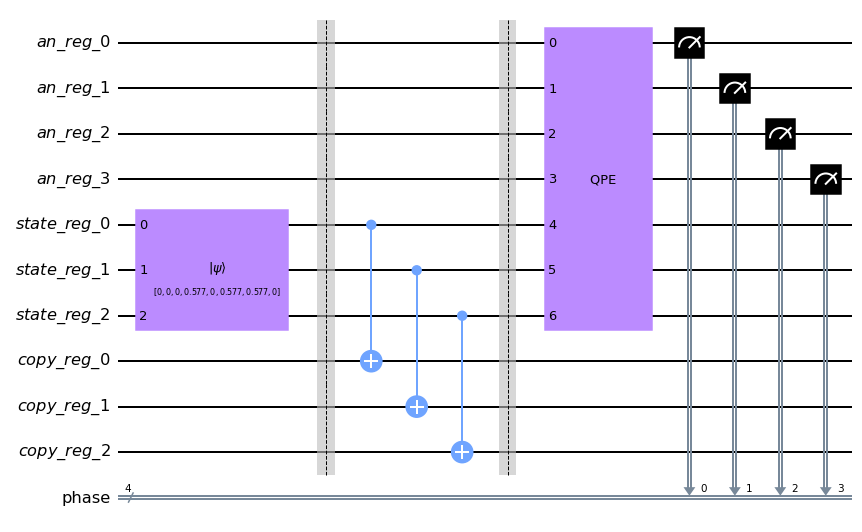

In [12]:
qc = qtda.initialize_projector(
    state_dict[1],
    circuit=qpe,
    initialization_qubits=list(range(num_qubits,num_qubits+n_vertices)),
    circuit_name='        QPE        '
    )
qc.add_register(ClassicalRegister(num_qubits, name="phase"))
for k in range(num_qubits):
    qc.measure(k,k)
qc.draw('mpl')

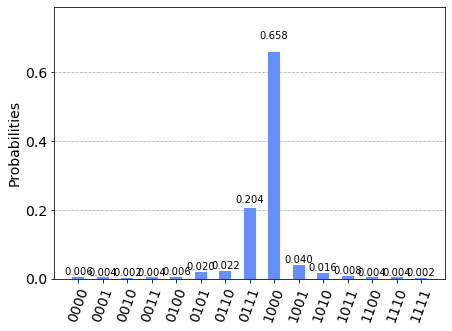

In [73]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=500)
data = job.result().get_counts(qc)
plot_histogram(data)

In [50]:
print('The number of 1-holes is: ', 3*data['0000']/500)

The number of 1-holes is:  0.006


In [37]:
def full_topological_analysis(num_qubits, n_vertices, state_dict, shots):
    
    for k in range(n_vertices):
        if (len(state_dict[k])==0):
            print("calculation terminated because no simplex of size ...")
            break
        qpe = qpe_total(num_qubits, n_vertices, k, state_dict)

        qc = qtda.initialize_projector(
            state_dict[k],
            circuit=qpe,
            initialization_qubits=list(range(num_qubits,num_qubits+n_vertices)),
            circuit_name='        QPE        '
            )
        qc.add_register(ClassicalRegister(num_qubits, name="phase"))
        for j in range(num_qubits-1):
            qc.measure(j,j)
        #qc.draw('mpl')
        backend = Aer.get_backend('qasm_simulator')
        job = execute(qc, backend, shots=shots)
        data = job.result().get_counts(qc)
        print("Loop k = %s. The dictionary of the data is:" %(k))
        print(data)
        print("Loop k = %s. The histogram is:" %(k))
        #plot_histogram(data)
        plt.bar(list(data.keys()), data.values(), color='g')
        plt.show()
        value = data.get("0000")
        if(value==None):
            value=0
        print("Number of shots: "+str(shots))
        print("state dict: "+str(state_dict))
        print("Total count of holes: %s " % (value*len(state_dict[k])/shots))

In [167]:
def example1():
    n_vertices = 3
    num_qubits = 4
    shots = 500

    S0 = [(0,0,1),(0,1,0), (1,0,0)]
    S_test = [(0,1,0,0),(0,0,1,1)]
    S1 = [(0,1,1),(1,1,0),(1,0,1)]
    S2 = []
    S2 = [(1,1,1)]
    S3 = []

    state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

    qpe = QuantumCircuit(num_qubits + n_vertices)

    full_topological_analysis(qpe, num_qubits, n_vertices, state_dict, shots)

Loop k = 0. The dictionary of the data is:
{'0000': 500}
Loop k = 0. The histogram is:


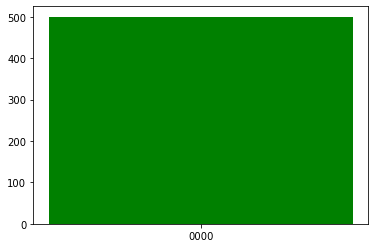

Number of shots: 500
state dict: {0: [(0, 0, 1), (0, 1, 0), (1, 0, 0)], 1: [(0, 1, 1), (1, 1, 0), (1, 0, 1)], 2: [(1, 1, 1)], 3: []}
Total count of holes: 3.0 
Loop k = 1. The dictionary of the data is:
{'0101': 48, '0001': 58, '0110': 72, '0100': 64, '0011': 55, '0111': 65, '0010': 63, '0000': 75}
Loop k = 1. The histogram is:


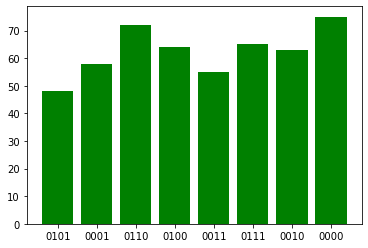

Number of shots: 500
state dict: {0: [(0, 0, 1), (0, 1, 0), (1, 0, 0)], 1: [(0, 1, 1), (1, 1, 0), (1, 0, 1)], 2: [(1, 1, 1)], 3: []}
Total count of holes: 0.45 
Loop k = 2. The dictionary of the data is:
{'0000': 500}
Loop k = 2. The histogram is:


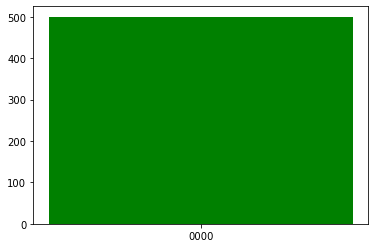

Number of shots: 500
state dict: {0: [(0, 0, 1), (0, 1, 0), (1, 0, 0)], 1: [(0, 1, 1), (1, 1, 0), (1, 0, 1)], 2: [(1, 1, 1)], 3: []}
Total count of holes: 1.0 


In [26]:
n_vertices = 3
num_qubits = 4
shots = 500

S0 = [(0,0,1),(0,1,0), (1,0,0)]
S_test = [(0,1,0,0),(0,0,1,1)]
S1 = [(0,1,1),(1,1,0),(1,0,1)]
S2 = []
S2 = [(1,1,1)]
S3 = []

state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

full_topological_analysis(num_qubits, n_vertices, state_dict, shots)

Two holes on a 4 point simplicial complex

Loop k = 0. The dictionary of the data is:
{'0110': 1, '0100': 15, '0001': 16, '0111': 6, '0011': 35, '0101': 246, '0000': 9, '0010': 672}
Loop k = 0. The histogram is:


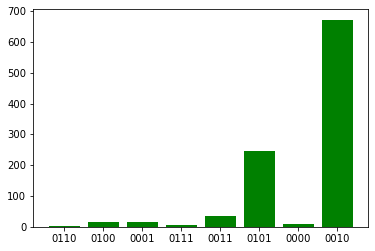

Number of shots: 1000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [], 3: []}
Total count of holes: 0.036 
Loop k = 1. The dictionary of the data is:
{'0110': 4, '0100': 5, '0001': 13, '0111': 2, '0011': 11, '0101': 215, '0010': 367, '0000': 383}
Loop k = 1. The histogram is:


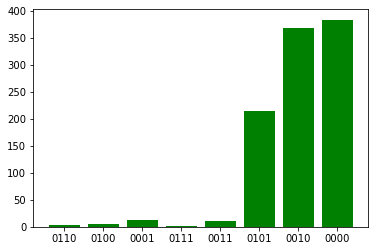

Number of shots: 1000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [], 3: []}
Total count of holes: 1.915 
calculation terminated because no simplex of size ...


In [38]:
def example2holes():

    n_vertices = 4
    num_qubits = 4
    shots = 1000

    S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
    S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)]
    S2 = []
    S3 = []

    state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

    full_topological_analysis(num_qubits, n_vertices, state_dict, shots)
    
example2holes()

Loop k = 0. The dictionary of the data is:
{'0100': 12, '0110': 7, '0001': 28, '0111': 7, '0011': 37, '0101': 257, '0000': 8, '0010': 644}
Loop k = 0. The histogram is:


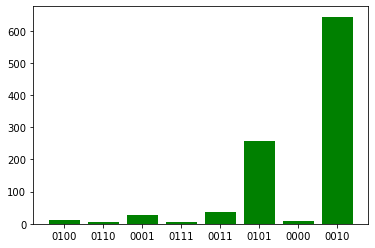

Number of shots: 1000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [(1, 0, 1, 1)], 3: []}
Total count of holes: 0.032 


In [ ]:
def example1hole():

    n_vertices = 4
    num_qubits = 4
    shots = 1000

    S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
    #S_test = [(0,1,0,0),(0,0,1,1)]
    S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)]
    S2 = [(1,0,1,1)]
    S3 = []

    state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

    full_topological_analysis(num_qubits, n_vertices, state_dict, shots)
    
example1hole()

Loop k = 0. The dictionary of the data is:
{'0110': 4, '0001': 13, '0100': 13, '0011': 41, '0111': 2, '0010': 700, '0000': 4, '0101': 223}
Loop k = 0. The histogram is:


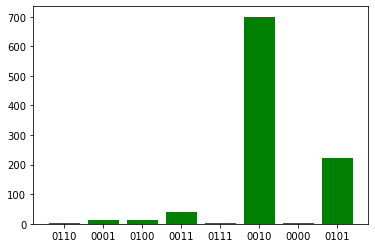

Number of shots: 1000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [(1, 0, 1, 1)], 3: []}
Total count of holes: 0.016 
Loop k = 1. The dictionary of the data is:
{'0110': 9, '0001': 21, '0100': 8, '0010': 370, '0000': 316, '0101': 215, '0011': 15, '0111': 46}
Loop k = 1. The histogram is:


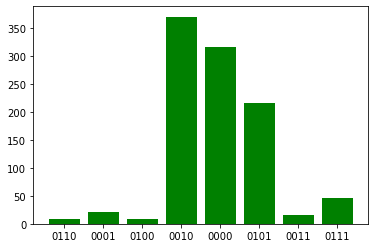

Number of shots: 1000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [(1, 0, 1, 1)], 3: []}
Total count of holes: 1.58 
Loop k = 2. The dictionary of the data is:
{'0101': 18, '0001': 47, '0110': 37, '0100': 10, '0011': 15, '0111': 195, '0010': 22, '0000': 656}
Loop k = 2. The histogram is:


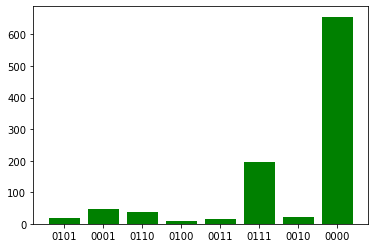

Number of shots: 1000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [(1, 0, 1, 1)], 3: []}
Total count of holes: 0.656 
calculation terminated because no simplex of size ...


In [174]:

n_vertices = 4
num_qubits = 4
shots = 1000

S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
#S_test = [(0,1,0,0),(0,0,1,1)]
S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)]
S2 = [(1,0,1,1)]
S3 = []

state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

qpe = QuantumCircuit(num_qubits + n_vertices)

full_topological_analysis(qpe, num_qubits, n_vertices, state_dict, shots)

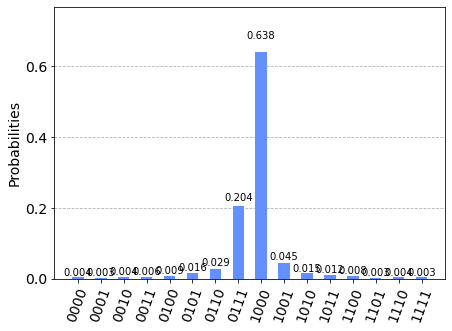

In [78]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=5000)
data = job.result().get_counts(qc)
plot_histogram(data)

In [52]:
def run_circuit(circuit):
    qasm_sim = Aer.get_backend('qasm_simulator')
    shots = 2048
    job = execute(circuit, qasm_sim, shots=1024)
    answer = job.result().get_counts(qc)
    return answer

{'0000': 2, '1110': 2, '0010': 3, '1010': 20, '0110': 31, '1100': 4, '0100': 7, '0101': 11, '0001': 3, '0011': 4, '0111': 215, '1101': 2, '1111': 3, '1000': 659, '1001': 49, '1011': 9}


(array([2., 1., 2., 1., 2., 1., 2., 1., 2., 2.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

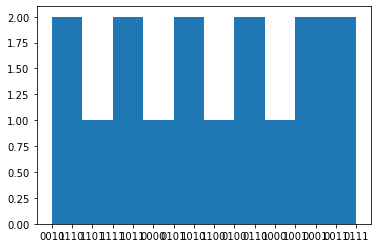

In [79]:
answer = run_circuit(qc)
print(answer)
plot_histogram(answer)